# LSTM for Encoder Decoder Network
## Time series analysis

### Introduction
In this notebook, we want to illustrate a problem arising in time series forecasting, while simultaneously showing how to properly use some Tensorflow features which greatly help in this setting (specifically, the `tf.data.Dataset` class and Keras’ functional API).

Imagine the following: we have a time series, *i.e.*, a sequence of values 

$$y(t_i) = y_i \qquad \mbox{at times} \qquad t_i$$ 

and we also have at each time step some auxiliary features 

$$X(t_i) = X_i$$

which we think are related with the values of $y_i$. 
Some of the components of $X_i$ might be known for all times (think of them as predetermined features, like whether time $t_i$ is a national holiday) whereas others are random and quite difficult to forecast in advance (say, the price of a Microsoft stock at time $t_i$).

If we want to train a model to forecast the future values of the time series we cannot use every feature, but rather we need to censor the features we would not be able to know at prediction time, as shown in the picture below.

![](https://www.angioi.com/assets/pics/encdec/table_time_series.svg)

For these kinds of tasks, a pretty straightforward procedure would be to use an autoregressive model of some kind (like *ARIMA*, *ARMAX*); these models allow us to take into account autocorrelations in a time series, and also can accept the deterministic features in the future (typically called “exogenous variables”). One limitation of ARMAX is that it is a linear model, and also one needs to specify the order of autocorrelations to be taken into account parametrically. 
LSTMs, instead, can learn nonlinear patterns, and are able to take into account autocorrelations in a nonparametric way!

In [1]:
# Load libraries
import tensorflow as tf

import pandas as pd
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format = "retina"
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

Here the strategy is the following

We encode past observations in a _latent space_, and then use the encoded past as a sort of “context” to then perform forecasts with an LSTM. In order to better illustrate this problem, let’s consider in the following section a concrete example.

# Importing data and building dataset

Let’s start with a practical example of a time series and look at the [UCI Bike Sharing Dataset](https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip); there we can find for each hour the amount of bikes rented by customers of a bike sharing service in Washington DC, together with other features such as whether a certain day was a national holiday, and which day of the week was it. The dataset can be downloaded with the following bash commands:

In [2]:
# Import dataset
%%bash
wget -N https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip
if [ ! -d "datasets/bike_data" ]; then mkdir -p datasets/bike_data; fi
unzip -o Bike-Sharing-Dataset.zip -d datasets/bike_data

--2020-06-18 13:37:49--  https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 279992 (273K) [application/x-httpd-php]
Saving to: ‘Bike-Sharing-Dataset.zip’

Bike-Sharing-Datase 100%[===================>] 273.43K   436KB/s    in 0.6s    

2020-06-18 13:37:50 (436 KB/s) - ‘Bike-Sharing-Dataset.zip’ saved [279992/279992]

Archive:  Bike-Sharing-Dataset.zip
  inflating: datasets/bike_data/Readme.txt  
  inflating: datasets/bike_data/day.csv  
  inflating: datasets/bike_data/hour.csv  


#### Goal
> predict the total bike usage for the week following prediction time. 

For the sake of simplicity, let’s skip a lot of data cleaning/feature engineering steps one could apply to this dataset, and just load it via the following:

In [2]:
df = pd.read_csv('datasets/bike_data/hour.csv', index_col='instant')

In [3]:
def select_columns(df):
    cols_to_keep = [       
      'cnt',
      'temp',
      'hum',
      'windspeed',
      'yr',
      'mnth', 
      'hr', 
      'holiday', 
      'weekday', 
      'workingday'
    ]
    df_subset = df[cols_to_keep]
    return df_subset

def onehot_encode_integers(df, excluded_cols):
    df = df.copy()

    int_cols = [col for col in df.select_dtypes(include=['int'])
              if col not in excluded_cols]

    df.loc[:,int_cols] = df.loc[:,int_cols].astype('str')

    df_encoded = pd.get_dummies(df)
    return df_encoded

def normalize_cnt(df):
    df = df.copy()
    df['cnt'] = df['cnt'] / df['cnt'].max()
    return df

As mentioned before, we want to feed the “past” plus some deterministic features in the future to a Keras model and get back a forecast; in order to make Keras accept this data, it has to be reshaped in an appropriate way. We need to split it into _windows_ where each row is a time step and each column correspond to a feature. Moreover, if we want to split the training into multiple batches we need to aggregate all these windows in a tensor of shape $(n_{\mathrm{batches}},n_{\mathrm{timesteps}},n_{\mathrm{features}})$ .

In [4]:
# I <3 pandas pipe
dataset = (df
           .pipe(select_columns)
           .pipe(onehot_encode_integers, 
                 excluded_cols=['cnt'])
           .pipe(normalize_cnt)
)

Since the dataset is already loaded in a Pandas DataFrame, we could easily do these steps with a mix of Pandas methods (`DataFrame.rolling()` & co.) and then transform the data into Numpy arrays (which TensorFlow can then ingest). I try to show here an approach I like more, that can work seamlessly for much larger datasets which do not fit in memory and has a very clean API: we initialize a `tf.data.Dataset` object from the data and then transform it via TensorFlow built-in functions. So, we can just define a function that returns the desired form of the dataset like this:

In [5]:
def create_dataset(df, n_deterministic_features, 
                   window_size, forecast_size, 
                   batch_size):
    # Feel free to play with shuffle buffer size
    shuffle_buffer_size = len(df)
    # Total size of window is given by the number of steps to be considered
    # before prediction time + steps that we want to forecast
    total_size = window_size + forecast_size

    data = tf.data.Dataset.from_tensor_slices(df.values)

    # Selecting windows
    data = data.window(total_size, shift=1, drop_remainder=True)
    data = data.flat_map(lambda k: k.batch(total_size))

    # Shuffling data (seed=Answer to the Ultimate Question of Life, the Universe, and Everything)
    data = data.shuffle(shuffle_buffer_size, seed=42)

    # Extracting past features + deterministic future + labels
    data = data.map(lambda k: ((k[:-forecast_size],
                             k[-forecast_size:,-n_deterministic_features:]),
                             k[-forecast_size:,0]))
  
    return data.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

Notice that aside from extracting windows out of the dataset and selecting the correct portions out of them, we also randomize the order of training examples we show to the model, batch it, and prefetch it. Via the `generate_dataset` function we can create `tf.data.Dataset` objects to feed to TensorFlow:

In [6]:
# Times at which to split train/validation and validation/test
val_time = 10000
test_time = 14000

# How much data from the past should we need for a forecast?
window_len = 24*7*3 # Three weeks
# How far ahead do we want to generate forecasts?
forecast_len = 24*5 # Five days

# Auxiliary constants
n_total_features = len(dataset.columns)
n_aleatoric_features = len(['cnt','temp','hum','windspeed'])
n_deterministic_features = n_total_features - n_aleatoric_features

# Splitting dataset into train/val/test
training_data = dataset.iloc[:val_time]
validation_data = dataset.iloc[val_time:test_time]
test_data = dataset.iloc[test_time:]

# Now we get training, validation, and test as tf.data.Dataset objects

batch_size = 32

training_windowed = create_dataset(training_data, 
                                   n_deterministic_features,
                                   window_len,
                                   forecast_len,
                                   batch_size)

validation_windowed = create_dataset(validation_data, 
                                     n_deterministic_features,
                                     window_len,
                                     forecast_len,
                                     batch_size)

test_windowed = create_dataset(test_data, 
                               n_deterministic_features,
                               window_len,
                               forecast_len,
                               batch_size=1)

# Model building/training (point predictions)

Now that the data is prepared, we need to define the model. The specifics of the neural architecture we are using here are not particularly optimized, but they follow from the basic idea that we want to encode past observations in a latent space, and then use the encoded past as a sort of “context” to then perform forecasts with an LSTM.

![](https://www.angioi.com/assets/pics/encdec/architecture.svg)

Thus, we can define the model pictured above via the Keras functional API as follows:

__CAREFUL__ training takes time here.

This gives us the occasion to talk about __GPU training__.

GPU are considered nowadays a core ingredient of deep learning. Indeed all deep learning frameworks (pythorch, Keras, TensorFlow, Cafè) have the possibility of making use of the GPU to train your model.

A nice discussion about these themes can be found [here](https://medium.com/@shachishah.ce/do-we-really-need-gpu-for-deep-learning-47042c02efe2#:~:text=Bandwidth%20is%20one%20of%20the,be%20used%20for%20other%20tasks.).

For a brief and simple explanation of `return_state` parameter in `LSTM`, on can have a look at [this blog post](https://machinelearningmastery.com/return-sequences-and-return-states-for-lstms-in-keras/).

In [7]:
latent_dim = 16

# First branch of the net is an lstm which finds an embedding for the past
past_inputs = tf.keras.Input(shape=(window_len,n_total_features), name='past_inputs')
# Encoding the past
encoder = tf.keras.layers.LSTM(latent_dim, return_state=True, name = 'Encoder')
encoder_outputs, state_h, state_c = encoder(past_inputs) # Apply the encoder object to past_inputs.

future_inputs = tf.keras.Input(shape=(forecast_len,n_deterministic_features), name='future_inputs')
# Combining future inputs with recurrent branch output
decoder_lstm = tf.keras.layers.LSTM(latent_dim, return_sequences=True, name = 'Decoder')
x = decoder_lstm(future_inputs, 
                               initial_state=[state_h, state_c])

x = tf.keras.layers.Dense(16, activation='relu')(x)
x = tf.keras.layers.Dense(16, activation='relu')(x)
output = tf.keras.layers.Dense(1, activation='relu')(x)

model = tf.keras.models.Model(inputs=[past_inputs,future_inputs], outputs=output)

optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.Huber()
model.compile(loss=loss, optimizer=optimizer, metrics=["mae"])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
past_inputs (InputLayer)        [(None, 504, 53)]    0                                            
__________________________________________________________________________________________________
future_inputs (InputLayer)      [(None, 120, 49)]    0                                            
__________________________________________________________________________________________________
Encoder (LSTM)                  [(None, 16), (None,  4480        past_inputs[0][0]                
__________________________________________________________________________________________________
Decoder (LSTM)                  (None, 120, 16)      4224        future_inputs[0][0]              
                                                                 Encoder[0][1]                

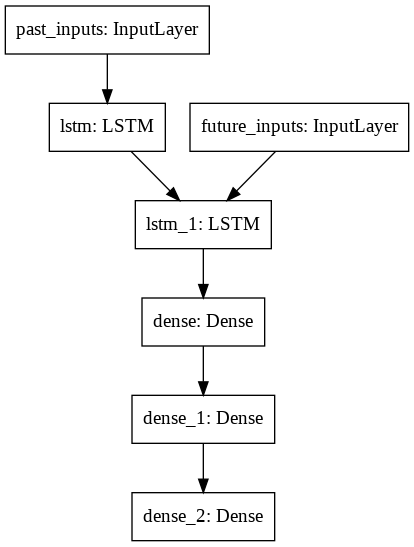

In [9]:
tf.keras.utils.plot_model(model)

In [10]:
history = model.fit(training_windowed,epochs=25, validation_data=validation_windowed)

Epoch 1/25
294/294 [==============================] - 43s 147ms/step - loss: 0.0033 - mae: 0.0545 - val_loss: 0.0078 - val_mae: 0.0942
Epoch 2/25
294/294 [==============================] - 35s 117ms/step - loss: 0.0013 - mae: 0.0338 - val_loss: 0.0075 - val_mae: 0.0922
Epoch 3/25
294/294 [==============================] - 35s 118ms/step - loss: 0.0012 - mae: 0.0322 - val_loss: 0.0069 - val_mae: 0.0892
Epoch 4/25
294/294 [==============================] - 34s 117ms/step - loss: 0.0012 - mae: 0.0312 - val_loss: 0.0079 - val_mae: 0.0972
Epoch 5/25
294/294 [==============================] - 34s 117ms/step - loss: 0.0012 - mae: 0.0306 - val_loss: 0.0074 - val_mae: 0.0915
Epoch 6/25
294/294 [==============================] - 35s 117ms/step - loss: 0.0011 - mae: 0.0300 - val_loss: 0.0076 - val_mae: 0.0949
Epoch 7/25
294/294 [==============================] - 34s 117ms/step - loss: 0.0011 - mae: 0.0297 - val_loss: 0.0072 - val_mae: 0.0913
Epoch 8/25
294/294 [==============================] - 3

Now it's time to evaluate our model.

In [11]:
model.evaluate(test_windowed)

2756/2756 [==============================] - 43s 16ms/step - loss: 0.0088 - mae: 0.0956


[0.008798547089099884, 0.09561186283826828]

We can check for the _mean squared error_ on the test set by calling `model.evaluate(test_windowed)` and we obtain for these Hyperparameters a mean absolute error in the interval $75$-$100$ bikes; not too bad! 

Some sample forecasts are pictured below, compared with the actual number of bikes in use after prediction time.

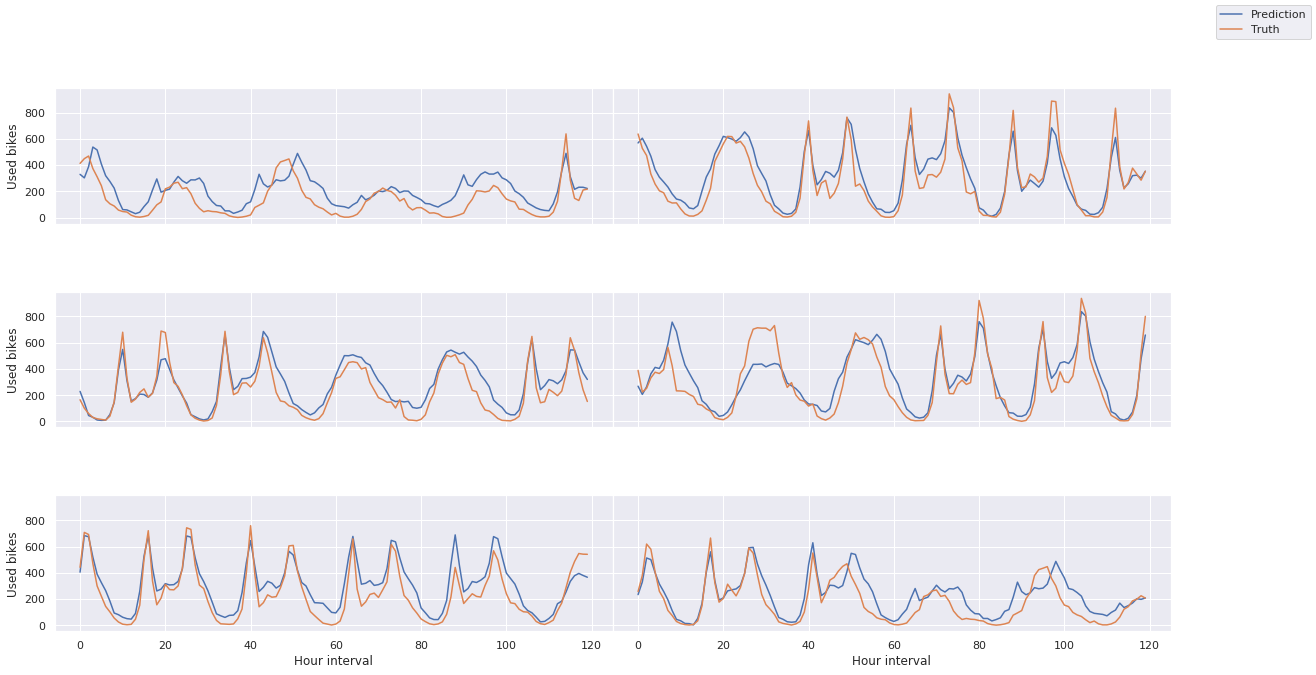

In [12]:
fig, ax = plt.subplots(nrows=3, ncols=2, sharex='all', sharey='all', figsize=(20, 10))

# We need to rescale cnt
scaling_factor = df.cnt.max()

for i, data in enumerate(test_windowed.take(6)):
    (past, future), truth = data

    truth = truth * scaling_factor
    pred = model.predict((past,future)) * scaling_factor

    row = i//2
    col = i%2

    ax[row][col].plot(pred.flatten(), label='Prediction')
    ax[row][col].plot(truth.numpy().flatten(),label='Truth')
    
# Labeling axes
for i in range(2):
    ax[2][i].set_xlabel('Hour interval')
for i in range(3):
    ax[i][0].set_ylabel('Used bikes')

handles, labels = ax[0][0].get_legend_handles_labels()
fig.subplots_adjust(wspace=0, hspace=0.5)
fig.legend(handles, labels, loc='upper right')

fig.show()

## Bonus: What if we want to forecast probability distributions?

In Time series analysis, point predictions are not the full story, and it is often of uttermost importance to be able to predict probability distributions. 

Luckily, since we built our model with TensorFlow, we can just make a slight modification to the head of the neural network and attach to it a __TensorFlow Probability distribution layer__; thus, we can define the model via the following cell.

The loss function now cannot be `MSE` or Huber anymore, because the model returns distributions. 
A natural choice here is to do maximize likelihood, which is equivalent to minimizing negative log-likelihood. This can be done by the following snippet of code

```python
negloglik = lambda y, p_y: -p_y.log_prob(y)

optimizer = tf.keras.optimizers.Adam(lr = 0.001)
model.compile(loss=negloglik,
              optimizer=optimizer)
```

and then we can fit, by simply calling `fit` method on the model instance.

In [13]:
import tensorflow_probability as tfp
tfd = tfp.distributions

# First branch of the net is an lstm which finds an embedding for the past
past_inputs = tf.keras.Input(shape=(window_len,n_total_features), name='past_inputs')
# Encoding the past
encoder = tf.keras.layers.LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(past_inputs)

future_inputs = tf.keras.Input(shape=(forecast_len,n_deterministic_features), name='future_inputs')
# Combining future inputs with recurrent branch output
decoder_lstm = tf.keras.layers.LSTM(latent_dim, return_sequences=True)
x = decoder_lstm(future_inputs, 
                               initial_state=[state_h, state_c])
x = tf.keras.layers.Dense(8, activation='relu')(x)
x = tf.keras.layers.Dense(8, activation='relu')(x)
x = tf.keras.layers.Dense(2, activation='relu')(x)
output = tfp.layers.DistributionLambda(
    lambda t: tfd.Normal(loc=t[...,0], 
                         scale=0.01*tf.math.softplus(t[...,1])),
    name='normal_dist')(x)

model = tf.keras.models.Model(inputs=[past_inputs,future_inputs], outputs=output)

negloglik = lambda y, p_y: -p_y.log_prob(y)

optimizer = tf.keras.optimizers.Adam(lr = 0.001)
model.compile(loss=negloglik,
              optimizer=optimizer)

history = model.fit(training_windowed,
                    epochs=25, 
                    validation_data=validation_windowed)

Epoch 1/25
294/294 [==============================] - 45s 154ms/step - loss: 19.6066 - val_loss: 3.9405
Epoch 2/25
294/294 [==============================] - 38s 130ms/step - loss: -0.8966 - val_loss: 1.1499
Epoch 3/25
294/294 [==============================] - 35s 120ms/step - loss: -1.1673 - val_loss: 0.5709
Epoch 4/25
294/294 [==============================] - 35s 120ms/step - loss: -1.2905 - val_loss: 0.2903
Epoch 5/25
294/294 [==============================] - 36s 121ms/step - loss: -1.3916 - val_loss: 0.3495
Epoch 6/25
294/294 [==============================] - 36s 121ms/step - loss: -1.4577 - val_loss: 0.5089
Epoch 7/25
294/294 [==============================] - 36s 121ms/step - loss: -1.5047 - val_loss: 0.5138
Epoch 8/25
294/294 [==============================] - 36s 121ms/step - loss: -1.5578 - val_loss: 0.6457
Epoch 9/25
294/294 [==============================] - 35s 121ms/step - loss: -1.6168 - val_loss: 0.8201
Epoch 10/25
294/294 [==============================] - 35s 121ms

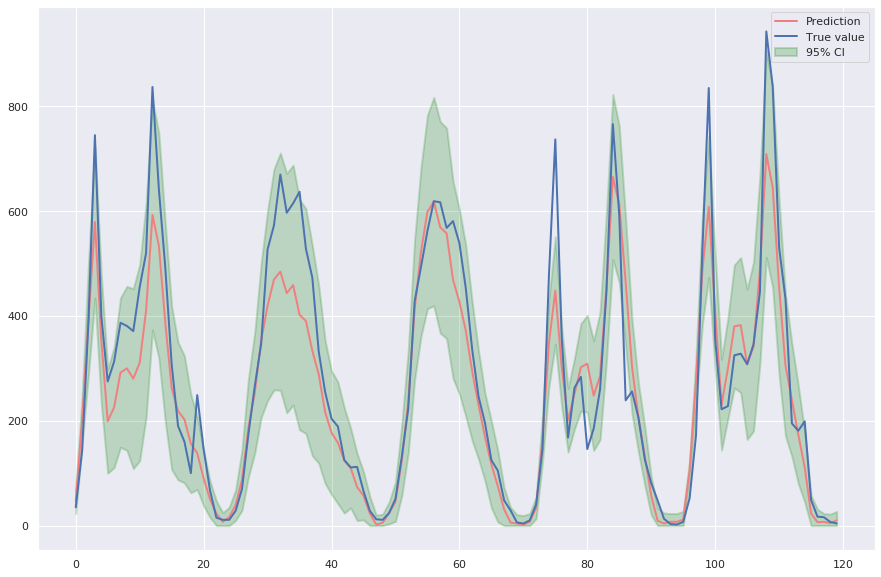

In [11]:
scaling_factor = df.cnt.max()
mean = lambda x: x.mean().numpy().flatten() * scaling_factor
sd = lambda x: x.stddev().numpy().flatten() * scaling_factor

t = np.array(range(forecast_len))

plt.figure(figsize=(15,10))

for i, data in enumerate(test_windowed.take(1)):
    (past, future), truth = data
    truth = truth * scaling_factor

    pred = model((past,future))

    plt.fill_between(t, 
                   mean(pred) + 2*sd(pred), 
                   (mean(pred) - 2*sd(pred)).clip(min=0),
                   color = 'green', label = '95% CI', alpha=0.2,
                   linewidth = 2)
    plt.plot(t,mean(pred), label='Prediction', color='lightcoral', linewidth = 2)
    plt.plot(t,truth.numpy().flatten(),label='True value', linewidth = 2)

plt.legend()
plt.show()

# Conclusion

A great source of inspiration is this keras tutorial about [encoder/decoder networks](https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html), have a look at it for a nice discussion about these architectures.

# Acknowledgment

This notebook takes a huge inspiration by the work of my dear friend [Alessandro Angioi](https://www.angioi.com/).